## Concept Study ✅

*   Given : 2 CSV files that represents user details and their engagements activities over time. 
*   Goal  :  
          1.   To identify "adopted users"
          2.   Identify which factors predict future user adoption






## Importing Datasets and necessary libraries/packages ✅

In [187]:
!pip install catboost
!pip install shap

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import catboost as cb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [189]:
userdata = pd.read_csv("/content/takehome_users.csv",encoding='latin')
userdata.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,22-04-2014 03:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,15-11-2013 03:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,19-03-2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,21-05-2013 08:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,17-01-2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [190]:
engagementdata = pd.read_csv("/content/takehome_user_engagement.csv")
engagementdata.head()

,time_stamp,user_id,visited
0,22-04-2014 03:53,1,1
1,15-11-2013 03:45,2,1
2,29-11-2013 03:45,2,1
3,09-12-2013 03:45,2,1
4,25-12-2013 03:45,2,1


## Exploratory Data Analytics ✅

**Missing Value Check**

In [191]:
userdata.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [192]:
engagementdata.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

**Inference**:


* *There are 2 features in userdata dataframe that has missing values, namely, `invited_by_user_id` and `last_session_creation_time`.*
* *engagementdata does not contain any missing values.*
* *Looking carefully into userdata dataframe, these are not missing values that can be imputed as,*
             1) Nobody has invited 5583 users to platform, hence the feature has missing values. 
             2) 3177 users has not logged in even once after creation of their accounts. 






**Feature Data-type check**

In [193]:
userdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [194]:
engagementdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


**Inference** :

* *`creation_time` and `invited_by_user_id` features should be datetime and integer variable respectively in userdata.*
*   *`time_stamp` feature should be datetime datatype, however, is object currently.*



**Data Duplication/Redundancy Check**

In [195]:
duplicate = userdata[userdata.duplicated()]
 
if len(duplicate) > 0:
  print("Data Duplication Found !!")
  print("Duplicated Rows:")
  print(duplicate)
else:
  print("No Duplication Found !!")

No Duplication Found !!


## Feature Engineering ✅

**Create new features `email_domain`,`year`**

In [196]:
# Converting creation_time feature to datetime dtype and Creating a new feature `year`

userdata["creation_time"] = pd.to_datetime(userdata["creation_time"])
userdata['year'] = userdata['creation_time'].dt.year

In [197]:
from datetime import datetime

def unix_to_datetime_convertor(unix_timestamp):
  if unix_timestamp != unix_timestamp:
    unix_val = 0
  else:
    unix_val = datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
  return unix_val

userdata["last_session_creation_datetime"] = userdata["last_session_creation_time"].apply(lambda x: unix_to_datetime_convertor(x))
userdata["last_session_creation_datetime"] = pd.to_datetime(userdata["last_session_creation_datetime"])

In [198]:
userdata.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,last_session_creation_datetime
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014,2014-04-22 03:53:30
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013,2014-03-31 03:45:04
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013,2013-03-19 23:14:52
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013,2013-05-22 08:09:28
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013,2013-01-22 10:14:20


In [199]:
userdata['difference_creation_lastlogin'] = (userdata['last_session_creation_datetime']- userdata['creation_time']).dt.days
userdata.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,last_session_creation_datetime,difference_creation_lastlogin
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014,2014-04-22 03:53:30,0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013,2014-03-31 03:45:04,136
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013,2013-03-19 23:14:52,0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013,2013-05-22 08:09:28,1
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013,2013-01-22 10:14:20,5


In [200]:
# Creating new feature `email_domain` from `email` feature

def email_domain_extractor(emailid):
  if '@' in emailid:
    domain = emailid.split('@')[-1]
  else:
    domain = "Invalid domain"
  return domain

userdata["email_domain"] = userdata["email"].apply(lambda x: email_domain_extractor(x))

In [201]:
# Imputing missing values in `invited_by_user_id` with value zero and converting this feature to integer dtype

userdata["invited_by_user_id"] = userdata["invited_by_user_id"].fillna(0)
userdata["invited_by_user_id"] = userdata["invited_by_user_id"].astype(int)

In [202]:
engagementdata["time_stamp"] = pd.to_datetime(engagementdata["time_stamp"])
engagementdata["year"] = engagementdata["time_stamp"].dt.year

In [203]:
#userdata.info()

In [204]:
#userdata.head()

In [205]:
engagementdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
 3   year        207917 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.3 MB


### Adopted Users Analysis ✅

Defining  an  "adopted  user" as a user who has logged into the product on three separate days in at least one seven ­day period,identify  which  factors  predict future user adoption

In [206]:
engagementdata["visited"].describe()

count    207917.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: visited, dtype: float64

Technique to find `adopted users`

1. Calculate unique users
2. Filter Users with 3 logins atleast
3. Filter users,who have logged in three separate days in at least one 7 day peroiod



In [207]:
total_engagements = len(engagementdata)
unique_engagements = len(engagementdata['user_id'].unique())

In [208]:
total_engagements,unique_engagements

(207917, 8823)

In [209]:
customers_with_3logins = engagementdata.groupby('user_id').filter(lambda x: len(x) >=3)

In [210]:
customers_with_3logins.head()

,time_stamp,user_id,visited,year
1,2013-11-15 03:45:00,2,1,2013
2,2013-11-29 03:45:00,2,1,2013
3,2013-09-12 03:45:00,2,1,2013
4,2013-12-25 03:45:00,2,1,2013
5,2013-12-31 03:45:00,2,1,2013


In [211]:
len(customers_with_3logins["user_id"].unique())

2248

In [212]:
#resetting the index
customers_with_3logins.reset_index(drop=True, inplace = True)

# Finding how many of the 2248 unique three-logins users are adopted users 
# who have logged in three separate days in at least one 7 day period 

adopted = 0
adopted_users = []
for i in range(len(customers_with_3logins)-2):
    user = customers_with_3logins['user_id'][i]
    if user != adopted and user == customers_with_3logins['user_id'][i+2]:
    # Get start date 
        sd = pd.Timestamp(customers_with_3logins['time_stamp'][i])
        # 7 days period end date
        ed = sd + pd.Timedelta('7D')
        if sd < pd.Timestamp(customers_with_3logins['time_stamp'][i+1]) < ed and sd < \
        pd.Timestamp(customers_with_3logins['time_stamp'][i+2]) < ed:
            adopted_users.append(user)
            adopted = user

In [213]:
len(adopted_users)

1447

In [214]:
y = pd.Series(np.random.randn(len(userdata)))
n = 0
for i in range(len(userdata)):
    if userdata['object_id'][i] == adopted_users[n]:
        y[i] = 1
        n = n+1
        if n > len(adopted_users)-1:
            n = n -1
    else:
        y[i] = 0
        
users2 = pd.DataFrame(y, columns = ['adopted_users'])
df = pd.concat([userdata, users2], axis=1)
print((df[df['adopted_users'] == 1]).count())

object_id                         1447
creation_time                     1447
name                              1447
email                             1447
creation_source                   1447
last_session_creation_time        1447
opted_in_to_mailing_list          1447
enabled_for_marketing_drip        1447
org_id                            1447
invited_by_user_id                1447
year                              1447
last_session_creation_datetime    1447
difference_creation_lastlogin     1447
email_domain                      1447
adopted_users                     1447
dtype: int64


In [215]:
df["adopted_users"] = df["adopted_users"].astype(int)

In [216]:
df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   object_id                       12000 non-null  int64         
 1   creation_time                   12000 non-null  datetime64[ns]
 2   name                            12000 non-null  object        
 3   email                           12000 non-null  object        
 4   creation_source                 12000 non-null  object        
 5   last_session_creation_time      8823 non-null   float64       
 6   opted_in_to_mailing_list        12000 non-null  int64         
 7   enabled_for_marketing_drip      12000 non-null  int64         
 8   org_id                          12000 non-null  int64         
 9   invited_by_user_id              12000 non-null  int64         
 10  year                            12000 non-null  int64         
 11  la

In [218]:
data = df.copy()

In [219]:
data = data.drop(["object_id","creation_time","name","email","last_session_creation_datetime","difference_creation_lastlogin"],axis=1)
data.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,email_domain,adopted_users
0,GUEST_INVITE,1.398139e+09,1,0,11,10803,2014,yahoo.com,0
1,ORG_INVITE,1.396238e+09,0,0,1,316,2013,gustr.com,0
2,ORG_INVITE,1.363735e+09,0,0,94,1525,2013,gustr.com,0
3,GUEST_INVITE,1.369210e+09,0,0,1,5151,2013,yahoo.com,0
4,GUEST_INVITE,1.358850e+09,0,0,193,5240,2013,yahoo.com,0


In [220]:
#new_data = pd.get_dummies(data, columns = ['creation_source'])
new_data = data

In [221]:
new_data["adopted_users"].value_counts()

0    10553
1     1447
Name: adopted_users, dtype: int64

### ML Modelling ✅

I am using CatBoost algorithm for ML Modelling to predict/identify features that are helpful in finding adopted users. 

Also, due to its explainability and interpretability, I have used CatBoost. Other algorithms that can be used are XGBoost. AutoML solutions like PyCaret can also be used. 

In [222]:
train = new_data.sample(frac=0.80,random_state=200) #random state is a seed value
test = new_data.drop(train.index)

In [223]:
train = train.reset_index(inplace=False)
#train = train.drop("index",axis=1)
train.head()

,index,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,email_domain,adopted_users
0,11385,PERSONAL_PROJECTS,NaN,0,0,123,0,2012,cuvox.de,0
1,11009,ORG_INVITE,1.381183e+09,0,0,211,11010,2013,jourrapide.com,1
2,587,SIGNUP,1.354621e+09,1,1,376,0,2012,gmail.com,0
3,1616,SIGNUP_GOOGLE_AUTH,1.401821e+09,0,0,78,0,2012,gmail.com,1
4,3365,PERSONAL_PROJECTS,NaN,0,0,175,0,2013,voixn.com,0


In [224]:
test = test.reset_index(inplace=False)
#test = test.drop("index",axis=1)
test.head()

,index,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,email_domain,adopted_users
0,2,ORG_INVITE,1.363735e+09,0,0,94,1525,2013,gustr.com,0
1,3,GUEST_INVITE,1.369210e+09,0,0,1,5151,2013,yahoo.com,0
2,5,GUEST_INVITE,1.387424e+09,0,0,197,11241,2013,yahoo.com,0
3,17,GUEST_INVITE,NaN,0,0,2,3153,2013,jourrapide.com,0
4,18,SIGNUP,1.369926e+09,1,0,0,0,2013,gmail.com,0


In [225]:
cat_features = ['creation_source','email_domain']
#text_features = ['text']

In [226]:
target_var = "adopted_users"
x_train = train.drop(target_var,axis=1)
y_train = train[target_var]
x_test = test.drop(target_var,axis=1)
y_test = test[target_var]

In [227]:
train_dataset = cb.Pool(x_train,y_train,cat_features=cat_features)
test_dataset = cb.Pool(x_test,y_test,cat_features=cat_features)

In [228]:
model = cb.CatBoostClassifier(eval_metric='AUC',
                              task_type = "GPU",
                              iterations=1000,
                              early_stopping_rounds=300)

In [229]:
model.fit(train_dataset, eval_set=test_dataset)

Learning rate set to 0.058753
0:	test: 0.9040420	best: 0.9040420 (0)	total: 24.9ms	remaining: 24.8s
1:	test: 0.9203854	best: 0.9203854 (1)	total: 67.1ms	remaining: 33.5s
2:	test: 0.9301206	best: 0.9301206 (2)	total: 118ms	remaining: 39.2s
3:	test: 0.9425657	best: 0.9425657 (3)	total: 194ms	remaining: 48.4s
4:	test: 0.9402782	best: 0.9425657 (3)	total: 262ms	remaining: 52s
5:	test: 0.9426551	best: 0.9426551 (5)	total: 301ms	remaining: 49.8s
6:	test: 0.9442674	best: 0.9442674 (6)	total: 353ms	remaining: 50.1s
7:	test: 0.9425682	best: 0.9442674 (6)	total: 406ms	remaining: 50.4s
8:	test: 0.9451104	best: 0.9451104 (8)	total: 452ms	remaining: 49.8s
9:	test: 0.9472944	best: 0.9472944 (9)	total: 491ms	remaining: 48.6s
10:	test: 0.9622724	best: 0.9622724 (10)	total: 534ms	remaining: 48s
11:	test: 0.9633582	best: 0.9633582 (11)	total: 573ms	remaining: 47.2s
12:	test: 0.9634041	best: 0.9634041 (12)	total: 617ms	remaining: 46.8s
13:	test: 0.9634108	best: 0.9634108 (13)	total: 644ms	remaining: 45.4

In [230]:
print(model.get_best_iteration())

327


In [231]:
pred = model.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2117
           1       0.92      0.76      0.84       283

    accuracy                           0.96      2400
   macro avg       0.95      0.88      0.91      2400
weighted avg       0.96      0.96      0.96      2400



Text(0.5, 0, 'CatBoost Feature Importance')

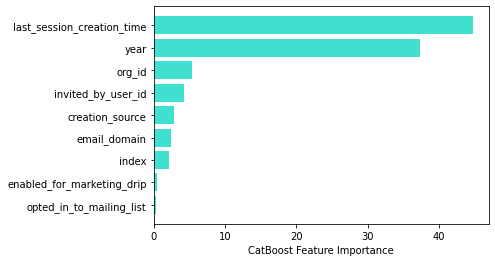

In [232]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [233]:
fig = px.bar(y = x_train.columns[sorted_feature_importance],x=model.feature_importances_[sorted_feature_importance],orientation='h',title="CatBoost Feature Importance")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

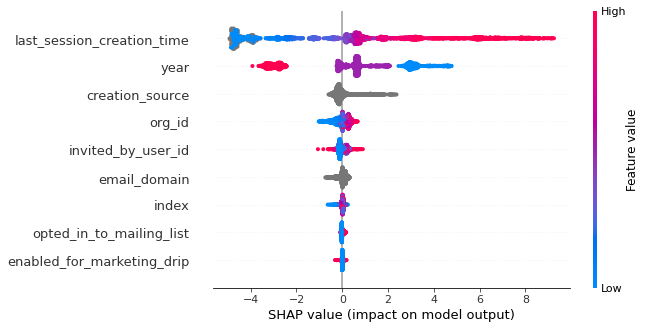

In [234]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

**INFERENCE** :

Clearly, `last_session_creation_time`,`year of account creation`,`creation_source` have very high impact on user adoption.

In [235]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,last_session_creation_datetime,difference_creation_lastlogin,email_domain,adopted_users
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,2014,2014-04-22 03:53:30,0,yahoo.com,0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,2013,2014-03-31 03:45:04,136,gustr.com,0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,2013,2013-03-19 23:14:52,0,gustr.com,0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,2013,2013-05-22 08:09:28,1,yahoo.com,0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,2013,2013-01-22 10:14:20,5,yahoo.com,0


In [236]:
adopted_userdata = df[df["adopted_users"]==1]
adopted_userdata.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,last_session_creation_datetime,difference_creation_lastlogin,email_domain,adopted_users
9,10,2013-01-16 22:08:00,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143,2013,2014-06-03 22:08:03,503,gustr.com,1
32,33,2014-11-03 06:29:00,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79,2014,2014-05-31 06:29:09,-156,cuvox.de,1
41,42,2012-11-11 19:05:00,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,0,2012,2014-05-25 19:05:07,560,cuvox.de,1
49,50,2012-03-06 11:02:00,Oliveira Gabrielly,GabriellyAlmeidaOliveira@gmail.com,GUEST_INVITE,1.350990e+09,0,0,61,50,2012,2012-10-23 11:02:08,231,gmail.com,1
52,53,2013-09-02 23:47:00,Ribeiro Camila,CamilaGomesRibeiro@gmail.com,GUEST_INVITE,1.367798e+09,0,0,37,3641,2013,2013-05-05 23:47:15,-120,gmail.com,1


### Analysis1: User Adoption w.r.t Email Domain

In [237]:
total_adopted_users = len(adopted_userdata)
print(total_adopted_users)

1447


In [238]:
adopted_userdata["email_domain"].value_counts().head(6).to_frame('counts')

,counts
gmail.com,484
yahoo.com,238
hotmail.com,180
jourrapide.com,151
gustr.com,126
cuvox.de,125


In [239]:
userdata["email_domain"].value_counts().head(6)

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
Name: email_domain, dtype: int64

In [240]:
email_adoptedusers = adopted_userdata["email_domain"].value_counts().head(6).to_frame('counts')
email_adoptedusers["total_mail"] = [3562,2447,1259,1202,1179,11665]

In [241]:
email_adoptedusers["percentage_adopted"] = email_adoptedusers["counts"] / email_adoptedusers["total_mail"]
email_adoptedusers

,counts,total_mail,percentage_adopted
gmail.com,484,3562,0.135879
yahoo.com,238,2447,0.097262
hotmail.com,180,1259,0.142971
jourrapide.com,151,1202,0.125624
gustr.com,126,1179,0.106870
cuvox.de,125,11665,0.010716


In [242]:
fig = px.bar(email_adoptedusers, y='percentage_adopted', x=email_adoptedusers.index,
            title="User Adoption Rate based on Email domain")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**INFERENCE**:

*The `percentage_adopted` feature has shown that there is `no significance change` in user adoption depending on email domain used to signup.*

### Analysis2 : User Adoption w.r.t Creation Source

In [243]:
val1 = adopted_userdata["creation_source"].value_counts().to_frame('counts')

In [244]:
val1["total_creation_source"] = userdata["creation_source"].value_counts().to_frame('counts')

In [245]:
val1["percentage_adopted"] = val1["counts"]/val1["total_creation_source"]

In [246]:
val1

,counts,total_creation_source,percentage_adopted
ORG_INVITE,504,4254,0.118477
GUEST_INVITE,325,2163,0.150254
SIGNUP,261,2087,0.125060
SIGNUP_GOOGLE_AUTH,212,1385,0.153069
PERSONAL_PROJECTS,145,2111,0.068688


In [247]:
import plotly.express as px

fig = px.bar(val1, x = val1.index, y='percentage_adopted',
             hover_data=['percentage_adopted'], color='percentage_adopted',height=400)

fig.update_layout(autosize=False,width=1000,height=500)
fig.show()

* *Looking at numbers of `percentage_adopted`, **users signing up through Google Authentication and Guest Invite** tend to be using the application comparatively more.*
* *Also, a nice information is that we have a huge numbers of users who are organizational invites. Enhancing their user-experience will increase user adoption significantly.*

## Year-On-Year User-Adoption Growth Plot ✅

In [248]:
val_df = pd.DataFrame()
val_df["user_adoption"] = adopted_userdata["year"].value_counts().to_frame('counts')
adopted_userdata["year"].value_counts()

2013    801
2012    417
2014    229
Name: year, dtype: int64

In [249]:
val_df["new_signups"] = userdata["year"].value_counts().to_frame('counts')
val_df = val_df.sort_index()
val_df

,user_adoption,new_signups
2012,417,2797
2013,801,5676
2014,229,3527


In [250]:
import plotly.graph_objects as go

# Add data
year = [2012,2013,2014]
user_adoption = [417,801,229]
new_signups = [2797,5676,3527]

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=year, y=user_adoption, name='Y-O-Y User Adoption',
                         line=dict(color='red', width=4)))
fig.add_trace(go.Scatter(x=year, y=new_signups, name = 'Y-O-Y New Sign-Ups',
                         line=dict(color='royalblue', width=4)))

# Edit the layout
fig.update_layout(title='Y-O-Y Platform Growth',
                   xaxis_title='Year',
                   yaxis_title='Count')


fig.show()

## User Distribution ✅

In [251]:
df["adopted_users"].value_counts()

0    10553
1     1447
Name: adopted_users, dtype: int64

In [252]:
dic = {"adopted_users":1447,"not visted":3177,"visited but not adopted":7376}

In [253]:
import plotly.graph_objects as go

labels = ["adopted_users","not visted","visited but not adopted"]
values = [1447, 3177, 7376]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()